In [1]:
using Distributed

using Pkg


@everywhere begin 
    using ParallelTemperingMonteCarlo
    using DelimitedFiles
    using BenchmarkTools
end

In [2]:
using Random
@everywhere import ..MCRun: initialise_histograms!,updatehistogram!,update_max_stepsize!,sampling_step!,save_results,save_states
Random.seed!(1234)


TaskLocalRNG()

In [6]:

# number of atoms
n_atoms = 13

# temperature grid
ti = 50.
tf = 160.
n_traj = 8

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details
mc_cycles = 400 #default 20% equilibration cycles on top
mc_sample = 1  #sample every mc_sample MC cycles

displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust, eq_percentage = 1)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
ico_13  = [[-0.0000000049,       -0.0000000044,       -0.0000000033],
[-0.0000007312,       -0.0000000014,        0.6554619119],
 [0.1811648930,      -0.5575692094,        0.2931316798],
[-0.4742970242,       -0.3445967289,        0.2931309525],
[-0.4742970303,        0.3445967144,        0.2931309494],
 [0.1811648830,        0.5575692066,        0.2931316748],
 [0.5862626299,        0.0000000022,        0.2931321262],
[-0.1811648928,       -0.5575692153,       -0.2931316813],
[-0.5862626397,       -0.0000000109,       -0.2931321327],
[-0.1811649028,        0.5575692007,       -0.2931316863],
 [0.4742970144,        0.3445967202,       -0.2931309590],
 [0.4742970205,       -0.3445967231,       -0.2931309559],
 [0.0000007214,       -0.0000000073,       -0.6554619185]]
 ico_55 = [[0.0000006584,       -0.0000019175,        0.0000000505],
 [-0.0000005810,       -0.0000004871,        0.6678432175],
 [0.1845874248,       -0.5681026047,        0.2986701538],
 [-0.4832557457,       -0.3511072166,        0.2986684497],
 [-0.4832557570,        0.3511046452,        0.2986669456],
 [0.1845874064,        0.5681000550,        0.2986677202],
 [0.5973371920,       -0.0000012681,        0.2986697030],
 [-0.1845860897,       -0.5681038901,       -0.2986676192],
 [-0.5973358752,       -0.0000025669,       -0.2986696020],
 [-0.1845861081,        0.5680987696,       -0.2986700528],
 [0.4832570624,        0.3511033815,       -0.2986683486],
 [0.4832570738,       -0.3511084803,       -0.2986668445],
 [0.0000018978,       -0.0000033480,       -0.6678431165],
 [-0.0000017969,        0.0000009162,        1.3230014650],
 [0.1871182835,       -0.5758942175,        0.9797717078],
 [-0.4898861924,       -0.3559221410,       0.9797699802],
 [-0.4898862039,        0.3559224872,        0.9797684555],
 [0.1871182648,        0.5758945856,        0.9797692407],
 [0.6055300485,        0.0000001908,        0.9797712507],
 [0.7926501864,       -0.5758950093,        0.6055339635],
 [0.3656681761,       -1.1254128670,        0.5916673591],
 [-0.3027660545,       -0.9318173412,        0.6055326929],
 [-0.9573332453,       -0.6955436707,        0.5916639831],
 [-0.9797705418,       -0.0000006364,        0.6055294407],
 [-0.9573332679,        0.6955423392,        0.5916610035],
 [-0.3027660847,        0.9318160902,        0.6055287012],
 [0.3656681396,        1.1254115783,        0.5916625380],
 [0.7926501677,        0.5758937939,        0.6055314964],
 [1.1833279992,       -0.0000006311,        0.5916664660],
 [0.6770051458,       -0.9318186223,        0.0000033028],
 [0.0000006771,       -1.1517907207,        0.0000025175],
 [-0.6770037988,       -0.9318186442,        0.0000007900],
 [-1.0954155825,       -0.3559242494,       -0.0000012200],
 [-1.0954155940,        0.3559203788,       -0.0000027447],
 [-0.6770038290,        0.9318147872,       -0.0000032017],
 [0.0000006397,        1.1517868856,       -0.0000024165],
 [0.6770051155,        0.9318148091,       -0.0000006889],
 [1.0954168993,        0.3559204143,        0.0000013211],
 [1.0954169108,       -0.3559242139,        0.0000028458],
 [0.3027674014,       -0.9318199253,       -0.6055286002],
 [-0.3656668229,       -1.1254154134,       -0.5916624370],
 [-0.7926488510,       -0.5758976290,       -0.6055313954],
 [-1.1833266824,       -0.0000032040,       -0.5916663649],
 [-0.7926488697,        0.5758911742,       -0.6055338624],
 [-0.3656668594,        1.1254090319,       -0.5916672580],
 [0.3027673712,        0.9318135061,       -0.6055325919],
 [0.9573345621,        0.6955398357,       -0.5916638820],
 [0.9797718586,       -0.0000031986,       -0.6055293396],
 [0.9573345846,       -0.6955461743,       -0.5916609025],
 [-0.1871169480,       -0.5758984207,       -0.9797691397],
 [-0.6055287318,       -0.0000040259,       -0.9797711497],
 [-0.1871169667,        0.5758903824,       -0.9797716067],
 [0.4898875091,        0.3559183059,       -0.9797698792],
 [0.4898875207,       -0.3559263223,       -0.9797683545],
 [0.0000031136,       -0.0000047513,       -1.3230013639]]
 #convert to Bohr
 nmtobohr = 18.8973
 copperconstant = 0.36258*nmtobohr
 pos_cu55 = copperconstant*ico_55
 pos_cu13 = copperconstant*ico_13*1.5
 AtoBohr = 1.8897259886
 
 # length(pos_cu55) == n_atoms || error("number of atoms and positions not the same - check starting config")
 
 #boundary conditions 
 bc_cu55 = SphericalBC(radius=14*AtoBohr)   #5.32 Angstrom
 bc_cu13 = SphericalBC(radius=8*AtoBohr)
 #starting configuration

#starting configuration
# start_config = Config(pos_cu13, bc_cu13)
start_config = Config(pos_cu55, bc_cu55)
 #histogram information
 n_bin = 100
 #en_min = -0.006    #might want to update after equilibration run if generated on the fly
 #en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)



#histogram information
n_bin = 100



runnerdir = "/home/ghun245/RuNNer-testing/Brass_potential/"
atomtype="Cu"

# RuNNer.getRuNNerenergy(runnerdir,1;input_idx=2)



pot=ParallelMLPotential(runnerdir,"Cu",1,Threads.nthreads())

copper_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

results = Output{Float64}(n_bin; en_min = copper_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[], Float64[])

In [10]:
# function testparallelrunner(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     Threads.@threads for i=1:4
#         for j=1:100
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end

# function testrunner(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     for i=1:4
#         for j=1:100
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end
# function testparallelrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     Threads.@threads for i=1:8
#         for j=1:10
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end

# function testrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vec)
#     for i=1:8
#         for j=1:10
#             mc_cycle!(parallel_states[i], move_strat, mc_params, pot_vec[i], ensemble, 1, a, v, r)
#         end
#     end
# end
parallel_states,pot_vec,a,v,r,delta_en = parallel_equilibration(copper_states,move_strat,mc_params,pot,ensemble,results,Threads.nthreads())
# @benchmark testrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vector)
# @benchmark testparallelrunner2(parallel_states,a,v,r,delta_en,n_threads,pot_vector)
# n_steps = 1

# @benchmark ParallelRun.pptmc_cycle(parallel_states,mc_params,results,move_strat,pot_vec,ensemble,n_threads,delta_en,n_steps,a,v,r)
#@time ParallelRun.pptmc_run!(mc_states,move_strat,mc_params,pot,ensemble,results)

Beginning Equilibration




equilibration done


(Any[MCState{Float64, 55, SphericalBC{Float64}}[MCState{Float64, 55, SphericalBC{Float64}}(50.0, 6315.499705261945, Config{55, SphericalBC{Float64}, Float64}(StaticArraysCore.SVector{3, Float64}[[4.5112139495856e-6, -1.3138293967695e-5, 3.4601504321700004e-7], [-0.04588731391204818, -0.10493194482843458, 4.480389041493115], [1.264752985534391, -3.8925157884546686, 2.0464230925690106], [-3.2908353973167697, -2.421147772806262, 2.077874606145081], [-3.311163596895427, 2.40569285113995, 2.0464011106786812], [1.202609458855352, 3.858622601881719, 2.119267072239834], [4.121412097898912, 0.019440194453212788, 2.0248158494050483], [-1.2696667093468017, -3.897825103318659, -2.0932279854277014], [-4.135252737379164, -0.07129060574305542, -1.9919256252821804], [-1.276924081637166, 3.867005021817807, -2.023354629596946]  …  [2.0744963372369405, 6.384583971948036, -4.148977939714466], [6.5594487104586, 4.765688045720408, -4.053952548518178], [6.713184197946128, -2.1916113212552402e-5, -4.148955655

We've concluded initial tests confirming that this is -- in principle -- possible to utilise several threads to run PTMC in parallel, there remain questions as to whether it is as effective as standard, serial PTMC. We test this now with Neon

In [3]:
Random.seed!(1234)

# number of atoms
n_atoms = 13

# temperature grid
ti = 5.
tf = 14.
n_traj = 15

temp = TempGrid{n_traj}(ti,tf) 

# MC simulation details
mc_cycles = 1008000 #default 20% equilibration cycles on top
mc_sample = 1  #sample every mc_sample MC cycles

#move_atom=AtomMove(n_atoms) #move strategy (here only atom moves, n_atoms per MC cycle)
displ_atom = 0.1 # Angstrom
n_adjust = 100

max_displ_atom = [0.1*sqrt(displ_atom*temp.t_grid[i]) for i in 1:n_traj]

mc_params = MCParams(mc_cycles, n_traj, n_atoms, mc_sample = mc_sample, n_adjust = n_adjust)

#moves - allowed at present: atom, volume and rotation moves (volume,rotation not yet implemented)
move_strat = MoveStrategy(atom_moves = n_atoms)  

#ensemble
ensemble = NVT(n_atoms)

#ELJpotential for neon
#c1=[-10.5097942564988, 0., 989.725135614556, 0., -101383.865938807, 0., 3918846.12841668, 0., -56234083.4334278, 0., 288738837.441765]
#elj_ne1 = ELJPotential{11}(c1)

c=[-10.5097942564988, 989.725135614556, -101383.865938807, 3918846.12841668, -56234083.4334278, 288738837.441765]
pot = ELJPotentialEven{6}(c)

#starting configurations
#icosahedral ground state of Ne13 (from Cambridge cluster database) in Angstrom
pos_ne13 = [[2.825384495892464, 0.928562467914040, 0.505520149314310],
[2.023342172678102,	-2.136126268595355, 0.666071287554958],
[2.033761811732818,	-0.643989413759464, -2.133000349161121],
[0.979777205108572,	2.312002562803556, -1.671909307631893],
[0.962914279874254,	-0.102326586625353, 2.857083360096907],
[0.317957619634043,	2.646768968413408, 1.412132053672896],
[-2.825388342924982, -0.928563755928189, -0.505520471387560],
[-0.317955944853142, -2.646769840660271, -1.412131825293682],
[-0.979776174195320, -2.312003751825495, 1.671909138648006],
[-0.962916072888105, 0.102326392265998,	-2.857083272537599],
[-2.023340541398004, 2.136128558801072,	-0.666071089291685],
[-2.033762834001679, 0.643989905095452, 2.132999911364582],
[0.000002325340981,	0.000000762100600, 0.000000414930733]]

#convert to Bohr
AtoBohr = 1.8897259886
pos_ne13 = pos_ne13 * AtoBohr

length(pos_ne13) == n_atoms || error("number of atoms and positions not the same - check starting config")

#boundary conditions 
bc_ne13 = SphericalBC(radius=6.0*AtoBohr)   #5.32 Angstrom

#starting configuration
start_config = Config(pos_ne13, bc_ne13)

#histogram information
n_bin = 100
#en_min = -0.006    #might want to update after equilibration run if generated on the fly
#en_max = -0.001    #otherwise will be determined after run as min/max of sampled energies (ham vector)

#construct array of MCState (for each temperature)
run_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]

#results = Output(n_bin, max_displ_vec)
results = Output{Float64}(n_bin; en_min = run_states[1].en_tot)

Output{Float64}(100, 0.0, 0.0, Float64[], Float64[], Float64[], Vector{Float64}[], Vector{Float64}[], Float64[], Float64[], Float64[], Float64[])

In [31]:
# ebounds=[100.,-100.]
# for j =1:8
#     ParallelRun.thermalise!(run_states,move_strat,mc_params,pot,ensemble,ebounds,13,13,0,0,10000)
# end

# energies = [run_states[i].en_tot for i in 1:mc_params.n_traj]
# println(energies," ",ebounds)

# en_test = dimer_energy_config(run_states[1].dist2_mat,13,pot)[2]
# println(run_states[1].en_tot, en_test)
# pstates=[]
# for j=1:8
#     temp_state = deepcopy(run_states)
#     push!(pstates,temp_state)
# end

# Threads.@threads for j=1:8
#     ParallelRun.thermalise!(pstates[j],move_strat,mc_params,pot,ensemble,ebounds,13,13,0,0,50000)
# end
# en_test = dimer_energy_config(pstates[1][1].dist2_mat,13,pot)[2]
# println(pstates[1][1].en_tot, en_test)

In [39]:
# mc_params.eq_cycles=1000000
parallel_states,pot_vector,a,v,r,delta_en,n_threads = parallel_equilibration(run_states,move_strat,mc_params,pot,ensemble,results,Threads.nthreads())
#energymatrix = []

# for i=1:n_threads
#     energies = [parallel_states[i][j].en_tot for j = 1:mc_params.n_traj]
#     push!(energymatrix,energies)
# end
# for i = 1:n_threads
#     for j in 1:n_traj
#         en_test = dimer_energy_config(parallel_states[i][j].dist2_mat,13,pot)[2]
#         if isapprox(en_test, energymatrix[i][j]) == false
#             println("It broke")
#             break
#         end
#     end
# end



Beginning Equilibration




equilibration done


Any[]

In [4]:
@time ParallelRun.pptmc_run!(run_states,move_strat,mc_params,pot,ensemble,results,save_dir=pwd())
# cd("/home/ghun245/ParallelTemperingMonteCarlo.jl/scripts/")
# multihistogram(results,temp)
# using DelimitedFiles
# analysisfile = open("analysis.NVT","r")
# analysis = readdlm(analysisfile)
# close(analysisfile)
# using Plots

# plot(analysis[2:end,1],analysis[2:end,3])
# png("cv.png")


# histfile = open("histograms.data","r")
# histograms = readdlm(histfile)
# close(histfile)
# energies = histograms[1,:]
# histogram_data = histograms[1:end,:]
# data = [histogram_data[i,:] for i in 1:n_traj]
# plot(energies,data,legend=false)
# png("histograms.png")


Beginning Equilibration




equilibration done
126 cycles of 1000 per 8 thread



cycle 10 of 126 complete



cycle 20 of 126 complete



cycle 30 of 126 complete



cycle 40 of 126 complete



cycle 50 of 126 complete



cycle 60 of 126 complete



cycle 70 of 126 complete



cycle 80 of 126 complete



cycle 90 of 126 complete



cycle 100 of 126 complete



cycle 110 of 126 complete



cycle 120 of 126 complete



main loop complete


beginning statistics




done
 97.602012 seconds (481.51 M allocations: 71.069 GiB, 18.95% gc time, 2.39% compilation time)


In [20]:
for j = 1:100
    ParallelRun.pptmc_cycle(parallel_states,mc_params,results,move_strat,pot_vector,ensemble,n_threads,delta_en,13,a,v,r,pwd())
end
energymatrix = []

for i=1:n_threads
    energies = [parallel_states[i][j].en_tot for j = 1:mc_params.n_traj]
    push!(energymatrix,energies)
end

for i = 1:n_threads
    for j in 1:n_traj
        en_test = dimer_energy_config(parallel_states[i][j].dist2_mat,13,pot)[2]
        if isapprox(en_test, energymatrix[i][j]) == false
            println("It broke at $i,$j")
            break
        end
    end
end
energymatrix

In [4]:
#using BenchmarkTools
times = []
for j=2:8
    
    run_states = [MCState(temp.t_grid[i], temp.beta_grid[i], start_config, pot; max_displ=[max_displ_atom[i],0.01,1.]) for i in 1:n_traj]
    results = Output{Float64}(n_bin; en_min = run_states[1].en_tot)   
    ttemp = @benchmark ParallelRun.pptmc_run!(run_states,move_strat,mc_params,pot,ensemble,results,save_dir="/home/ghun245/ParallelTemperingMonteCarlo.jl/scripts/",n_threads=$j)
    
    push!(times,ttemp)
end
trials = times
times = [median(trials[i]).time for i in 1:7]
pushfirst!(times,191476000000)
x = [i for i=1:8]
plot(x,times/(1e9),legend = false,xlabel="threads",ylabel="trial time (s)")

Beginning Equilibration




equilibration done
504 cycles of 1000 per 2 thread



main loop complete


beginning statistics




done


Beginning Equilibration




equilibration done
504 cycles of 1000 per 2 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
504 cycles of 1000 per 2 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
504 cycles of 1000 per 2 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
336 cycles of 1000 per 3 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
336 cycles of 1000 per 3 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
336 cycles of 1000 per 3 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
336 cycles of 1000 per 3 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
252 cycles of 1000 per 4 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
252 cycles of 1000 per 4 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
252 cycles of 1000 per 4 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
252 cycles of 1000 per 4 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
201 cycles of 1000 per 5 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
201 cycles of 1000 per 5 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
201 cycles of 1000 per 5 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
201 cycles of 1000 per 5 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
168 cycles of 1000 per 6 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
168 cycles of 1000 per 6 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
168 cycles of 1000 per 6 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
168 cycles of 1000 per 6 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
144 cycles of 1000 per 7 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
144 cycles of 1000 per 7 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
144 cycles of 1000 per 7 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
144 cycles of 1000 per 7 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
126 cycles of 1000 per 8 thread



main loop complete


beginning statistics


done
Beginning Equilibration




equilibration done
126 cycles of 1000 per 8 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
126 cycles of 1000 per 8 thread



main loop complete


beginning statistics


done


Beginning Equilibration




equilibration done
126 cycles of 1000 per 8 thread



main loop complete


beginning statistics


done


Above is a plot demonstrating the improvement additional threads provide 

In [41]:
@benchmark ParallelRun.threadexchange!(parallel_states,n_threads,rand(1:mc_params.n_traj))

BenchmarkTools.Trial: 10000 samples with 695 evaluations.
 Range (min … max):  156.049 ns … 94.437 μs  ┊ GC (min … max):  0.00% … 98.99%
 Time  (median):     210.306 ns              ┊ GC (median):     0.00%
 Time  (mean ± σ):   334.685 ns ±  1.432 μs  ┊ GC (mean ± σ):  14.67% ±  3.92%

  ▅█▇▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁ ▁                                  ▂
  ██████████████████████████████████▇██▇▇▆▇▇▆▇▅▆▆▆▆▆▆▆▅▅▅▄▅▅▆▄ █
  156 ns        Histogram: log(frequency) by time      1.07 μs <

 Memory estimate: 125 bytes, allocs estimate: 3.

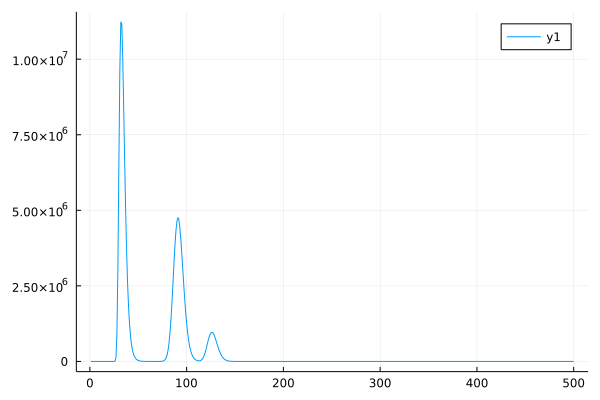

In [6]:
rdf1 = results.rdf[1]
#import Pkg; Pkg.add("Plots")

using Plots
plot(rdf1)